In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pickle 
import sys
# setting path
sys.path.append('../')
 
# # importing
from src.second_spectrum_utils import get_home_away_tracking
import src.player_velocities as vel
import src.pitch_control as pc
import src.visualizations as viz
from kloppy import secondspectrum

import src.statsbomb_util as sb

In [19]:
with open("C:\\Users\\LiamMoore\\Downloads\\merged_df.pkl", 'rb') as f:
    merged_df = pickle.load(f)

In [22]:
merged_df['type_name'].unique()

array(['Pass', 'Carry', 'Shot', 'Duel'], dtype=object)

In [3]:
META_PATH = "C:\\Users\\LiamMoore\\Documents\\code\\python\\City-DS\\Data\\g2312166_SecondSpectrum_meta.xml"
RAW_PATH = "C:\\Users\\LiamMoore\\Documents\\code\\python\\City-DS\\Data\\g2312166_SecondSpectrum_tracking-produced.jsonl"
EVENT_PATH = "C:\\Users\\LiamMoore\\Documents\\code\\python\\City-DS\\Data\\ManCity_Liverpool_events.json"

PARAMS = pc.parameters()

dataset = secondspectrum.load(
    meta_data=META_PATH,
    raw_data=RAW_PATH,
    
    # Optional arguments
    sample_rate=1/1,
    coordinates="secondspectrum",
    only_alive=False)

home_df, away_df = get_home_away_tracking(dataset)
tracking_home = vel.calc_player_velocities(home_df,smoothing=True,filter_='moving_average')
tracking_away = vel.calc_player_velocities(away_df,smoothing=True,filter_='moving_average')

In [6]:
import json
with open(EVENT_PATH) as file:
    json_data = json.load(file)

events_df = pd.json_normalize(json_data)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\LiamMoore\\Documents\\code\\python\\City-DS\\Data\\ManCity_Liverpool_events.json'

In [ ]:
events_df.loc[events_df.possession==5][['type.name', 'minute', 'second', 'team.id', 'team.name', 'location']]

,type.name,minute,second,team.id,team.name,location
60,Goal Keeper,1,45,966,Liverpool WFC,"[3.5, 39.3]"
61,Carry,1,45,966,Liverpool WFC,"[3.5, 39.3]"
62,Pass,1,49,966,Liverpool WFC,"[20.2, 38.5]"
63,Pressure,1,54,746,Manchester City WFC,"[28.1, 6.4]"
64,Ball Receipt*,1,55,966,Liverpool WFC,"[95.5, 74.5]"
65,Carry,1,55,966,Liverpool WFC,"[95.5, 74.5]"
66,Miscontrol,1,55,966,Liverpool WFC,"[94.9, 75.3]"


In [ ]:
merged_df.conrol_matrix.values[0].shape

(32, 50)

In [7]:
import numpy as np
import math 

def add_obv(row):
    matrix = np.zeros(row.conrol_matrix.shape)
    val = [row.obv_for_before]
    pos = [(row.event_location_in_matrix[1], row.event_location_in_matrix[0])]
    rows, cols = zip(*pos)
    matrix[rows, cols] = val
    matrix + row.conrol_matrix
    return matrix + row.conrol_matrix

In [8]:
merged_df['event_location_in_matrix'] = merged_df.location.apply(lambda x: [math.floor(i/2.45) - 1 for i in x])
merged_df['obv_obso'] = merged_df.apply(lambda x: add_obv(x), axis=1)
merged_df.head()

,event_id,index,period_id_x,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,time_sec,frame_id,ball_state,ball_owning_team_id,attacking_team,frame,value,conrol_matrix,event_location_in_matrix,obv_obso
0,9e527a78-b536-45c7-8129-b7130170f7e1,5,1,1681948801168,0,1,2,0.015598,0.006829,0.008769,...,1.16,29,alive,away,away,29,0,"[[0.0, 0.0, 0.0, 1.175143364150473e-15, 9.4734...","[23, 15]","[[0.0, 0.0, 0.0, 1.175143364150473e-15, 9.4734..."
1,b9899f6f-5587-46aa-9f9e-e2f9823e55a5,7,1,1681948802329,0,2,2,0.015397,0.015598,-0.000201,...,2.32,58,alive,away,away,58,0,"[[0.0, 0.0, 0.0, 0.0, 2.2664500598432182e-15, ...","[17, 18]","[[0.0, 0.0, 0.0, 0.0, 2.2664500598432182e-15, ..."
2,de84d7e8-6b96-476c-a928-6d59c2326295,8,1,1681948803204,0,3,2,0.010824,0.015397,-0.004573,...,3.20,80,alive,away,away,80,0,"[[0.0, 0.0, 0.0, 0.0, 2.5047423063273324e-16, ...","[17, 17]","[[0.0, 0.0, 0.0, 0.0, 2.5047423063273324e-16, ..."
3,632a16b5-6e82-450b-9895-f9a1b776af21,10,1,1681948806225,0,6,2,0.011461,0.010824,0.000637,...,6.20,155,alive,away,away,155,0,"[[0.0, 0.0, 0.0, 0.0, 2.46901209304493e-16, 1....","[4, 15]","[[0.0, 0.0, 0.0, 0.0, 2.46901209304493e-16, 1...."
4,ed6e3229-fa69-4897-bde3-60660e745664,11,1,1681948807981,0,7,2,0.010457,0.011461,-0.001004,...,8.00,200,alive,away,away,200,0,"[[0.0, 0.0, 4.232596730897403e-16, 2.127868640...","[5, 14]","[[0.0, 0.0, 4.232596730897403e-16, 2.127868640..."


In [64]:
merged_df['obso'] = merged_df.conrol_matrix.apply(lambda x : np.sum(x))
merged_df[['obv_for_before', 'obv_for_after', 'obso']].corr()

,obv_for_before,obv_for_after,obso
obv_for_before,1.000000,0.744511,0.545568
obv_for_after,0.744511,1.000000,0.469092
obso,0.545568,0.469092,1.000000


In [12]:
merged_df.attacking_team = np.where(merged_df.attacking_team=='home', 'Home', 'Away')

c:\Users\LiamMoore\Documents\code\python\City-DS\notebooks\..\src\visualizations.py:164: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ball_y'], 'ko', color="yellow", markersize=6, alpha=1.0, linewidth=1)


off ball expected threat: 0.6%


(<Figure size 1200x800 with 2 Axes>, <Axes: >)

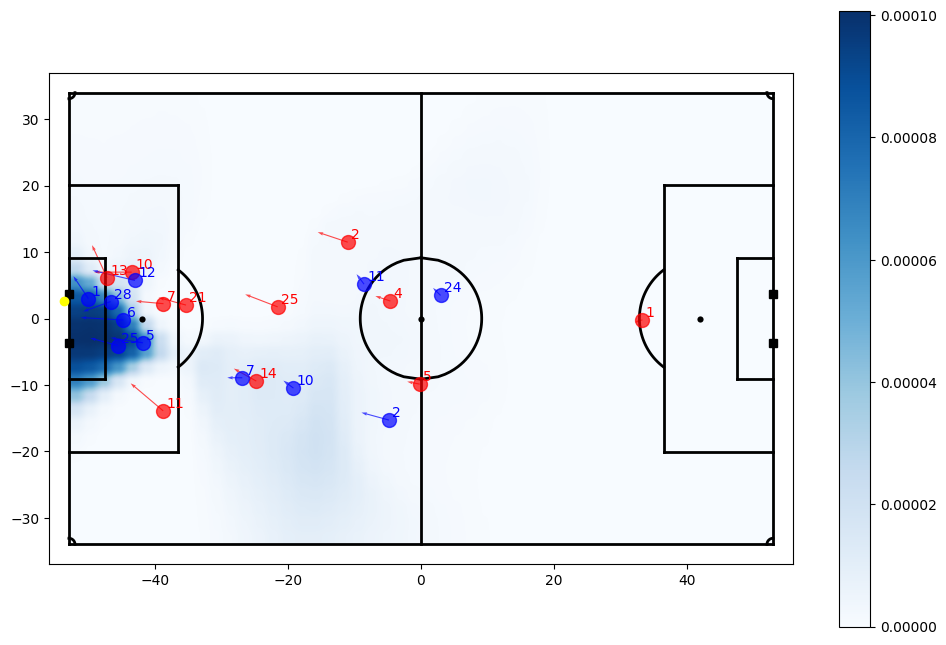

In [13]:
max = merged_df.loc[merged_df.obso==merged_df.obso.max()]
viz.plot_scoring_opp_for_frame(max.frame.values[0], tracking_home, tracking_away, max.attacking_team.values[0], PARAMS)

In [16]:
possession = merged_df.loc[merged_df.possession==43]

In [17]:
possession.conrol_matrix.values[0]

array([[2.49931974e-07, 3.26912465e-07, 4.16563973e-07, ...,
        6.25522632e-06, 5.01432402e-06, 3.90988727e-06],
       [2.61139828e-07, 3.41572403e-07, 4.43133330e-07, ...,
        5.80081033e-06, 4.67205681e-06, 3.56434797e-06],
       [2.71325683e-07, 3.54895559e-07, 4.60417908e-07, ...,
        5.44229937e-06, 4.35661451e-06, 3.15709123e-06],
       ...,
       [2.92584942e-08, 3.82702793e-08, 4.96493165e-08, ...,
        2.78024565e-07, 2.34751333e-07, 1.91741456e-07],
       [2.38773900e-08, 3.12317639e-08, 4.05180145e-08, ...,
        2.28355118e-07, 1.96041683e-07, 1.64759386e-07],
       [1.93770754e-08, 2.53453265e-08, 3.28813418e-08, ...,
        1.84083807e-07, 1.61026242e-07, 1.37029085e-07]])

In [18]:
import numpy as np
from numpy import unravel_index

def get_max_min(row):
    max_index = unravel_index(row.conrol_matrix.argmax(), row.conrol_matrix.shape)
    min_index = unravel_index(row.conrol_matrix.argmin(), row.conrol_matrix.shape)
    row['matrix_max'] = possession.conrol_matrix.values[0][max_index[0]][max_index[1]]
    row['matrix_min'] = possession.conrol_matrix.values[0][min_index[0]][min_index[1]]
    return row

In [19]:
possession = possession.apply(lambda x: get_max_min(x), axis=1)
possession['scaled_matrix'] = (possession.conrol_matrix - possession.matrix_max) / (possession.matrix_min - possession.matrix_max)
possession.head()

C:\Users\LiamMoore\AppData\Local\Temp\ipykernel_10152\2441088191.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  possession['scaled_matrix'] = (possession.conrol_matrix - possession.matrix_max) / (possession.matrix_min - possession.matrix_max)


,event_id,index,period_id_x,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,attacking_team,frame,value,conrol_matrix,event_location_in_matrix,obv_obso,obso,matrix_max,matrix_min,scaled_matrix
272,0d9219f1-84e6-4e76-a166-fa5e956aeb2a,514,1,1681949701216,15,1,43,0.024468,0.027224,-0.002756,...,Home,22530,0,"[[2.49931974373672e-07, 3.2691246472249507e-07...","[34, 22]","[[2.49931974373672e-07, 3.2691246472249507e-07...",0.011510,0.000064,1.484520e-12,"[[0.996092659246829, 0.9948891685990304, 0.993..."
273,03714c0b-a4a7-448e-b602-c2c9f6dd5431,516,1,1681949702678,15,2,43,0.022486,0.024468,-0.001982,...,Home,22567,0,"[[4.0202711473233486e-07, 5.072012032591706e-0...","[32, 23]","[[4.0202711473233486e-07, 5.072012032591706e-0...",0.012115,0.000015,2.150892e-11,"[[0.9733317443497822, 0.9663547036317419, 0.95..."
274,c8b94a0f-a2bb-4ab7-98aa-f8d79271a5f3,517,1,1681949703908,15,3,43,0.020029,0.022486,-0.002457,...,Home,22598,0,"[[6.593760236766682e-07, 8.409996464519983e-07...","[29, 22]","[[6.593760236766682e-07, 8.409996464519983e-07...",0.011865,0.000013,3.066910e-10,"[[0.9489630494736139, 0.9348984960330919, 0.91..."
275,a1f6a42e-db53-4a5f-9523-0ac892243a75,519,1,1681949704664,15,4,43,0.018907,0.020029,-0.001122,...,Home,22616,0,"[[2.655408468345544e-07, 3.513466525884398e-07...","[29, 27]","[[2.655408468345544e-07, 3.513466525884398e-07...",0.012571,0.000015,3.066910e-10,"[[0.9818382776829992, 0.9759627854690878, 0.96..."
276,727a6090-1f8c-426c-999b-4e6c292573a0,520,1,1681949705278,15,5,43,0.025024,0.018907,0.006117,...,Home,22632,0,"[[1.6219414061317915e-07, 2.1458619932907833e-...","[29, 28]","[[1.6219414061317915e-07, 2.1458619932907833e-...",0.013075,0.000016,2.150892e-11,"[[0.9898876962378715, 0.9866207799466532, 0.98..."


In [20]:
merged_df.possession_team_name.unique()

array(['Liverpool WFC', 'Manchester City WFC'], dtype=object)

In [21]:
possession['cumsum_matrix'] = possession.conrol_matrix.cumsum()

C:\Users\LiamMoore\AppData\Local\Temp\ipykernel_10152\1618279122.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  possession['cumsum_matrix'] = possession.conrol_matrix.cumsum()


NameError: name 'possession' is not defined

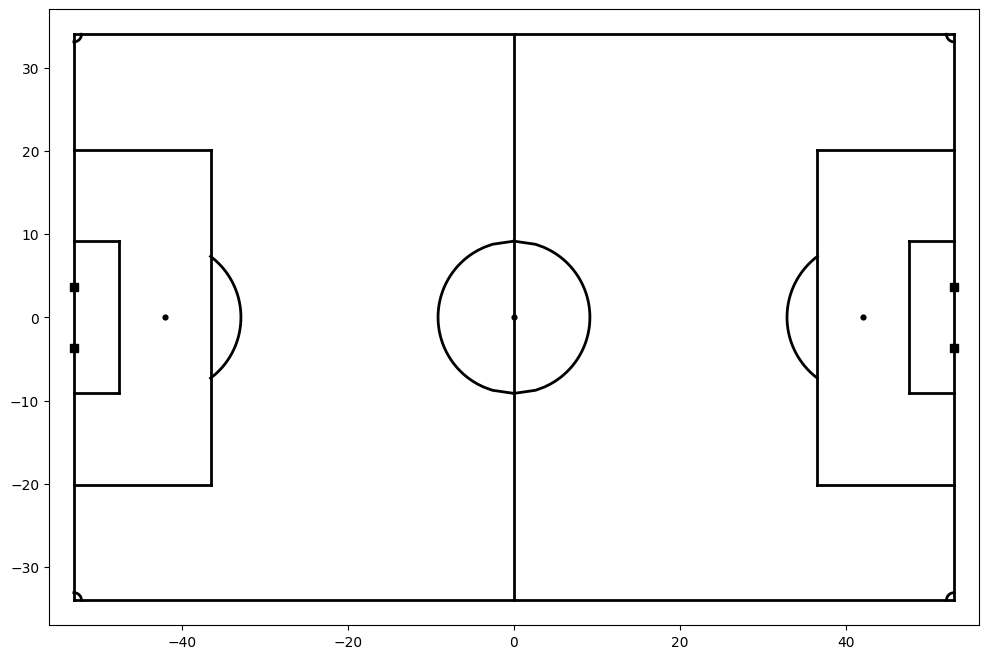

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
 
fig, ax = viz.plot_pitch(field_color='white', field_dimen=(106., 68.,))
 
def animate(i):
    ax.clear()
    # Get the point from the points list at index i
    row = possession.iloc[i]
    # Plot that point using the x and y coordinates
    viz.plot_frame_players(row.frame, tracking_home, tracking_away, row.attacking_team, row.cumsum_matrix, fig=fig, ax=ax)

ani = FuncAnimation(fig, animate, frames=len(possession),
                    interval=500, repeat=False)
plt.close()

In [23]:
animate(1)

c:\Users\LiamMoore\Documents\code\python\City-DS\notebooks\..\src\visualizations.py:164: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ball_y'], 'ko', color="yellow", markersize=6, alpha=1.0, linewidth=0)


In [42]:
# viz.animate_frames(fig, ax, df_, tracking_home, tracking_away)

In [25]:
result = np.zeros(possession.conrol_matrix.values[0].shape)
for matrix in possession.conrol_matrix.values:
    result += matrix

In [26]:
result

array([[1.81057046e-06, 2.34059336e-06, 3.01347580e-06, ...,
        1.73353920e-04, 1.29212010e-04, 9.72466830e-05],
       [1.86285263e-06, 2.42304789e-06, 3.08052409e-06, ...,
        9.69327742e-05, 7.31059729e-05, 5.47692475e-05],
       [1.88852011e-06, 2.45635008e-06, 3.17048655e-06, ...,
        4.65331089e-05, 3.52955500e-05, 2.61447561e-05],
       ...,
       [1.18302438e-07, 1.54178525e-07, 1.99444090e-07, ...,
        1.97301293e-05, 1.65017329e-05, 1.31153932e-05],
       [9.51232376e-08, 1.24003270e-07, 1.60457048e-07, ...,
        1.75529785e-05, 1.50081305e-05, 1.22779643e-05],
       [7.60929610e-08, 9.92241376e-08, 1.28434694e-07, ...,
        1.54180744e-05, 1.34065759e-05, 1.12337528e-05]])

In [145]:
incorrect_frame = possession.iloc[27]

IndexError: single positional indexer is out-of-bounds

In [198]:
def plot_actions(df, grid):
    field_dimen=(106., 68.,)
    fig, ax = viz.plot_pitch(field_color='white', field_dimen=(106., 68.,))
    xgrid = np.linspace(-field_dimen[0]/2., field_dimen[0]/2., 50)
    n_grid_cells_y = int(50*field_dimen[1]/field_dimen[0])
    ygrid = np.linspace(-field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y)
    im = ax.imshow(np.flipud(grid), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),
                   interpolation='hanning', vmin=0.0, vmax=np.max(grid), cmap="Reds")
    cbar = fig.colorbar(im)
    for index, row in df.iterrows():
        if index <= len(df)-2:
            ax.plot(row.location[0]+3, row.location[1]+3, df.iloc[index+1].location[0]+3, df.iloc[index+1].location[1]+3, lw=1.5, color='red')
            ax.scatter(row.location[0]-3, row.location[1]-3, color='red')
            # ax.scatter(df.iloc[index+1].location[0], df.iloc[index+1].location[1], facecolors='none', edgecolors='red')
            ax.annotate(text=str(index),xy=(row.location[0]-3, row.location[1]-3), color='red')

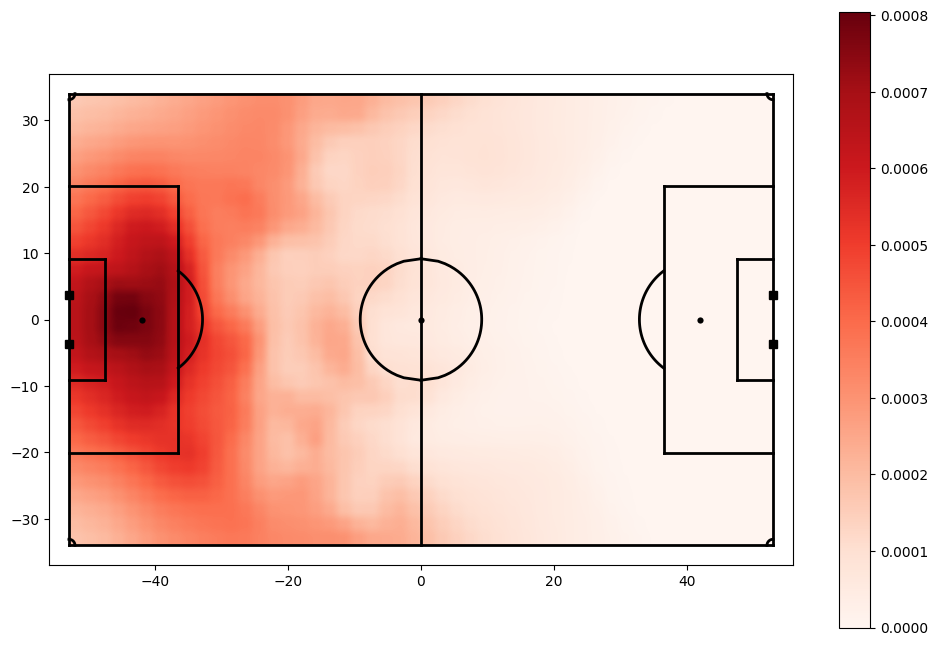

In [199]:
plot_actions(possession, result)

Find points when OBSO swings in x seconds

In [79]:
def find_changes(row, df, second, threshold):
    vals = df.loc[((df.time - row.time) <= second) & ((row.time - df.time) < 0) & (df.period_id_x==row.period_id_x)]
    vals['obso'] = np.where(vals.team_id==row.team_id, vals.obso, -vals.obso)
    vals['current_obso'] = row.obso
    vals['change'] = (vals.obso - vals.current_obso) / vals.current_obso * 100
    over_change = vals.loc[vals.change >= threshold]
    over_raw = vals.loc[vals['obso'] >= 0.015]
    if len(over_change) > 0 and len(over_raw) > 0:
        return True
    return False

In [74]:
def find_obso_swings(df, second, threshold):
    df['high_impact'] = df.apply(lambda x: find_changes(x, df, second, threshold), axis=1)
    impact_df = df.loc[df.high_impact==True]
    impact_df['next_time_diff'] = impact_df.time.shift(-1) - impact_df.time
    impact_df = impact_df.loc[(impact_df.next_time_diff > 3) & (impact_df.next_time_diff > 0)]
    result = []
    for _, row in impact_df.iterrows():
        result.append(df.loc[(df.period_id_x==row.period_id_x) & (df.time >= (row.time - (second*2.5))) & (df.time <= (row.time + (second*2.5)))])
    return result, impact_df

In [77]:
second_thresh = 3
change_thresh = 20 #pct_change in obso
impact_dfs, high_impact_plays = find_obso_swings(merged_df, second_thresh, change_thresh)

C:\Users\LiamMoore\AppData\Local\Temp\ipykernel_11436\2594008601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impact_df['next_time_diff'] = impact_df.time.shift(-1) - impact_df.time


In [82]:
impact_dfs[0][['minute', 'second', 'obso']].head()

,event_id,index,period_id_x,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,time_sec,frame_id,ball_state,ball_owning_team_id,attacking_team,frame,value,conrol_matrix,obso,high_impact
94,ba565250-fc51-49aa-b898-6c36ef3d8f1f,173,1,1681949035475,3,55,9,0.016011,0.014938,0.001073,...,235.48,5887,alive,home,home,5887,0,"[[1.2545104074124548e-06, 1.4532650151171412e-...",0.008616,False
95,8f04c5a0-2fc8-4377-a79a-c3a257a285cd,175,1,1681949036594,3,56,9,0.014814,0.016011,-0.001197,...,236.60,5915,alive,home,home,5915,0,"[[1.4656015507648831e-06, 1.6978482192789402e-...",0.008644,False
96,638b5580-1abf-4563-9c51-422c5939d55f,176,1,1681949037606,3,57,9,0.024241,0.014814,0.009427,...,237.60,5940,alive,home,home,5940,0,"[[1.233781859826081e-06, 1.4961247664739096e-0...",0.009633,False
97,5da455dd-2ff9-4e4a-aad9-12dce46d1a43,178,1,1681949041140,4,1,9,0.025076,0.024241,0.000835,...,241.12,6028,alive,home,home,6028,0,"[[1.3671916162769625e-07, 1.8484519465230786e-...",0.012008,True
98,5ac7de5a-93d8-4e80-9a4b-503599058c9a,179,1,1681949042181,4,2,9,0.013330,0.025076,-0.011746,...,242.20,6055,alive,home,home,6055,0,"[[2.7955707716924476e-08, 3.915470782006457e-0...",0.016345,False


c:\Users\LiamMoore\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


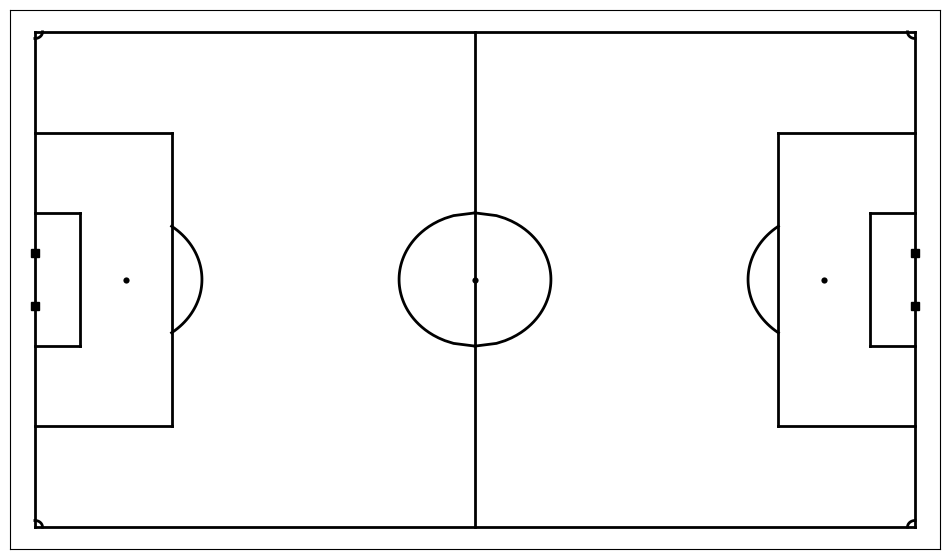

In [41]:
# viz.animate(3, impact_dfs[0], tracking_home, tracking_away)
fig, ax = viz.plot_pitch(field_color='white', field_dimen=(106., 68.,))
viz.animate_frames(fig, ax, impact_dfs[0], tracking_home, tracking_away)

In [47]:
fig, ax = viz.plot_pitch(field_color='white', field_dimen=(106., 68.,))


ani = FuncAnimation(fig, viz.animate, frames=len(impact_dfs[0]),
                    interval=500, repeat=False, fargs=(fig, ax, impact_dfs[0], tracking_home, tracking_away), blit=True)
plt.close()
# Save the animation as an animated GIF
ani.save("example.gif", dpi=300,
         writer=PillowWriter(fps=1))

c:\Users\LiamMoore\Documents\code\python\City-DS\notebooks\..\src\visualizations.py:168: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ball_y'], 'ko', color="yellow", markersize=6, alpha=1.0, linewidth=1)
c:\Users\LiamMoore\Documents\code\python\City-DS\notebooks\..\src\visualizations.py:168: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ball_y'], 'ko', color="yellow", markersize=6, alpha=1.0, linewidth=1)
c:\Users\LiamMoore\Documents\code\python\City-DS\notebooks\..\src\visualizations.py:168: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ba

In [38]:
impact_dfs[0][['obso', 'time', 'period_id_x', 'team_id', 'attacking_team']]

,obso,time,period_id_x,team_id,attacking_team
94,0.008616,235.47,1,746,Away
95,0.008644,236.59,1,746,Away
96,0.009633,237.61,1,746,Away
97,0.012008,241.14,1,746,Away
98,0.016345,242.18,1,746,Away
99,0.006150,244.18,1,966,Away
100,0.006379,245.83,1,966,Away
101,0.006416,245.87,1,966,Away


In [299]:
merged_df.obso.describe()

count    1547.000000
mean        0.010727
std         0.004612
min         0.004642
25%         0.007592
50%         0.009065
75%         0.012240
max         0.032697
Name: obso, dtype: float64

c:\Users\LiamMoore\Documents\code\python\City-DS\notebooks\..\src\visualizations.py:164: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ball_y'], 'ko', color="yellow", markersize=6, alpha=1.0, linewidth=0)


off ball expected threat: 2.2%


(<Figure size 1200x800 with 2 Axes>, <Axes: >)

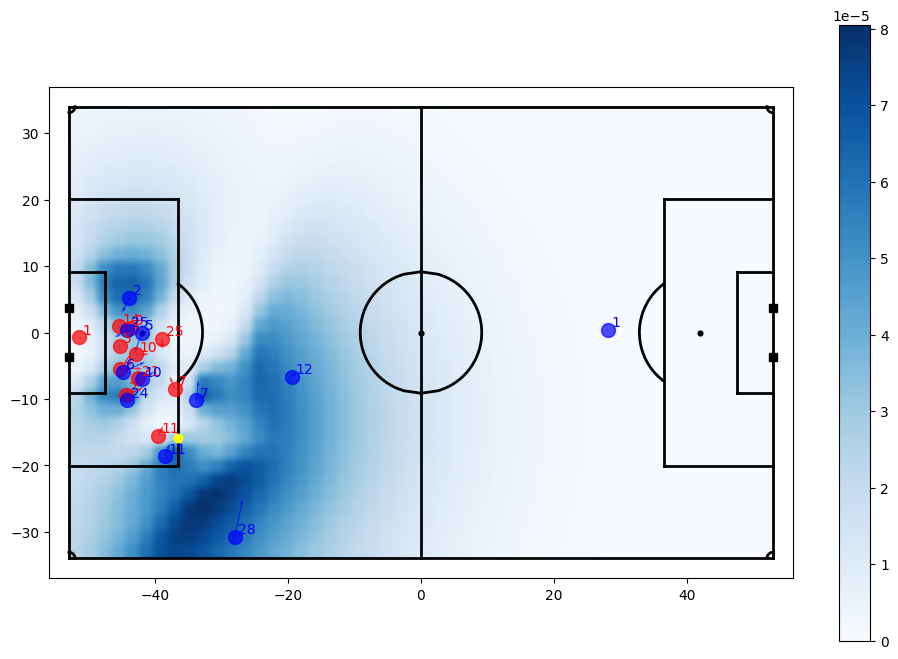

In [258]:
viz.plot_scoring_opp_for_frame(high_impact_plays.frame.values[1], tracking_home, tracking_away, high_impact_plays.attacking_team.values[1], PARAMS)